In [1]:
import torch
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from typing import List, Any, Tuple
from pathlib import Path
from collections import defaultdict
from collections import namedtuple
import struct
import matplotlib as mpl
from time import time
from tensorboardX import SummaryWriter
from tqdm import tqdm

import sys
sys.path.append('../')
from src.models import compile_model
from src.tools import SimpleLoss, get_batch_iou, get_val_info
from src.tools import normalize_img, denormalize_img, img_transform
from src.tools import load_config

%matplotlib inline

### Dataloader

In [2]:
cfg = load_config("../configs/kitti360_config.yaml")
cfg_data = cfg['DATA']
cfg_train = cfg['TRAIN']

grid_conf = {
    'xbound': cfg_data['xbound'],
    'ybound': cfg_data['ybound'],
    'zbound': cfg_data['zbound'],
    'dbound': cfg_data['dbound'],
}

data_aug_conf = {
                'resize_lim': cfg_data['resize_lim'],
                'final_dim': cfg_data['final_dim'],
                'rot_lim': cfg_data['rot_lim'],
                'H': cfg_data['H'], 'W': cfg_data['W'],
                'rand_flip': cfg_data['rand_flip'],
                'bot_pct_lim': cfg_data['bot_pct_lim'],
                'cams': cfg_data['cams'],
                'Ncams': cfg_data['ncams'],
                }

In [3]:
# a label and all meta information
Label = namedtuple('Label', [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'kittiId'     , # An integer ID that is associated with this label for KITTI-360
                    # NOT FOR RELEASING

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

LABELS = [
    #       name                     id    kittiId,    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,       -1 ,       255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,       -1 ,       255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,       -1 ,       255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,       -1 ,       255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,       -1 ,       255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,       -1 ,       255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,       -1 ,       255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        1 ,         0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        3 ,         1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,        2 ,       255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,        10,       255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        11,         2 , 'construction'    , 2       , True         , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        7 ,         3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        8 ,         4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,        30,       255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,        31,       255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,        32,       255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        21,         5 , 'object'          , 3       , True         , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,       -1 ,       255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        23,         6 , 'object'          , 3       , True         , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        24,         7 , 'object'          , 3       , True         , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        5 ,         8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        4 ,         9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,        9 ,        10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,        19,        11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,        20,        12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,        13,        13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,        14,        14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,        34,        15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,        16,       255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,        15,       255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,        33,        16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,        17,        17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,        18,        18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'garage'               , 34 ,        12,         2 , 'construction'    , 2       , True         , False        , ( 64,128,128) ),
    Label(  'gate'                 , 35 ,        6 ,         4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'stop'                 , 36 ,        29,       255 , 'construction'    , 2       , True         , True         , (150,120, 90) ),
    Label(  'smallpole'            , 37 ,        22,         5 , 'object'          , 3       , True         , False        , (153,153,153) ),
    Label(  'lamp'                 , 38 ,        25,       255 , 'object'          , 3       , True         , False        , (0,   64, 64) ),
    Label(  'trash bin'            , 39 ,        26,       255 , 'object'          , 3       , True         , False        , (0,  128,192) ),
    Label(  'vending machine'      , 40 ,        27,       255 , 'object'          , 3       , True         , False        , (128, 64,  0) ),
    Label(  'box'                  , 41 ,        28,       255 , 'object'          , 3       , True         , False        , (64,  64,128) ),
    Label(  'unknown construction' , 42 ,        35,       255 , 'void'            , 0       , False        , True         , (102,  0,  0) ),
    Label(  'unknown vehicle'      , 43 ,        36,       255 , 'void'            , 0       , False        , True         , ( 51,  0, 51) ),
    Label(  'unknown object'       , 44 ,        37,       255 , 'void'            , 0       , False        , True         , ( 32, 32, 32) ),
    Label(  'license plate'        , -1 ,        -1,        -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]


#--------------------------------------------------------------------------------
# Create dictionaries for a fast lookup
#--------------------------------------------------------------------------------

# # Please refer to the main method below for example usages!
# COLORS = np.concatenate([np.array(label.color).reshape(-1, 3) for label in LABELS if label.id != -1], axis=0)

# # name to label object
# NAME_TO_LABEL = {label.name: label for label in LABELS}

# # id to label object
# ID_TO_LABEL = {label.id: label for label in LABELS}

# # trainId to label object
# TRAINID_TO_LABEL = {label.trainId: label for label in reversed(LABELS)}

# # KITTI-360 ID to cityscapes ID
# KITTIID_TO_LABEL = {label.kittiId: label for label in LABELS}

# # category to list of label objects

# CATEGORY_TO_LABELS = {}

# for label in LABELS:
#     category = label.category
#     if category in CATEGORY_TO_LABELS:
#         CATEGORY_TO_LABELS[category].append(label)
#     else:
#         CATEGORY_TO_LABELS[category] = [label]

In [4]:
class KITTI360_Map(torch.utils.data.Dataset):

    CLASSES = [label.name for label in LABELS]

    def __init__(
            self,
            config,
            is_train=True,
    ):
        self.cfg = config
        self.is_train = is_train

        if self.is_train:
            self.seqs = [
#                          '2013_05_28_drive_0000_sync',
                         '2013_05_28_drive_0003_sync',
#                          '2013_05_28_drive_0004_sync',
#                          '2013_05_28_drive_0005_sync',
#                          '2013_05_28_drive_0006_sync',
#                          '2013_05_28_drive_0007_sync',
#                          '2013_05_28_drive_0009_sync',
#                          '2013_05_28_drive_0010_sync',
                        ]
        else:
#             self.seqs = ['2013_05_28_drive_0002_sync']
            self.seqs = ['2013_05_28_drive_0003_sync']
        masks_dirs = [os.path.join(self.cfg["DATA"]["dataroot"], f'data_3d_semantics/{seq}/bev_maps/') \
                          for seq in self.seqs]
        images_dirs = {
                      'image_00': [os.path.join(self.cfg["DATA"]["dataroot"], \
                                                f'data_2d_raw/{seq}/image_00/data_rect/') \
                                       for seq in self.seqs],
                      'image_01': [os.path.join(self.cfg["DATA"]["dataroot"], \
                                                f'data_2d_raw/{seq}/image_01/data_rect/') \
                                       for seq in self.seqs]
                      }
        
        flatten = lambda t: [item for sublist in t for item in sublist]

        self.ids = [os.listdir(masks_dir) for masks_dir in masks_dirs]
        self.cams_images_fps = {
            'image_00': flatten([[os.path.join(imgs_dir, self.maskid_to_imgid(image_id)) \
                                 for image_id in self.ids[idx]] \
                                 for idx, imgs_dir in enumerate(images_dirs['image_00'])]),
            'image_01': flatten([[os.path.join(imgs_dir, self.maskid_to_imgid(image_id)) \
                                 for image_id in self.ids[idx]] \
                                 for idx, imgs_dir in enumerate(images_dirs['image_01'])]),
        }
        self.masks_fps = flatten([[os.path.join(masks_dir, image_id) for image_id in self.ids[idx]] \
                                     for idx, masks_dir in enumerate(masks_dirs)])

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in self.cfg['DATA']['classes']]

        # intrinsics and extrinsics
        calib_dir = '%s/calibration' % (self.cfg["DATA"]["dataroot"])
        self.intrinsic_file = os.path.join(calib_dir, 'perspective.txt')
        self.extrinsics_file = os.path.join(calib_dir, 'calib_cam_to_pose.txt')

        assert os.path.isfile(self.intrinsic_file), '%s does not exist!' % self.intrinsic_file
        self.K, self.width, self.height = self.load_intrinsics()
        # print ('Image size %dx%d ' % (self.height, self.width))
        # print ('Intrinsics \n', self.K)
        assert os.path.isfile(self.extrinsics_file), '%s does not exist!' % self.extrinsics_file
        self.cams_to_pose = self.load_calibration_camera_to_pose()

        print(self)

    def maskid_to_imgid(self, fname):
        base_fname = '0000000000.png'
        img_fname = base_fname[:-len(fname)] + fname
        return img_fname
        
    def choose_cams(self):
        if self.is_train and self.cfg["DATA"]['ncams'] < len(self.cfg["DATA"]['cams']):
            cams = np.random.choice(self.cfg["DATA"]['cams'], self.cfg["DATA"]['ncams'],
                                    replace=False)
        else:
            cams = self.cfg["DATA"]['cams']
        return cams

    def load_intrinsics(self):
        # load intrinsics
        intrinsic_loaded = False
        width = -1
        height = -1
        with open(self.intrinsic_file) as f:
            intrinsics = f.read().splitlines()
        for line in intrinsics:
            line = line.split(' ')
            if line[0] == 'P_rect_00:':
                K = [float(x) for x in line[1:]]
                K = np.reshape(K, [3, 4])
                intrinsic_loaded = True
            if line[0] == "S_rect_00:":
                width = int(float(line[1]))
                height = int(float(line[2]))
        assert (intrinsic_loaded == True)
        assert (width > 0 and height > 0)

        return K[:3, :3], width, height

    @staticmethod
    def read_variable(fid, name, M, N):
        # rewind
        fid.seek(0, 0)

        # search for variable identifier
        line = 1
        success = 0
        while line:
            line = fid.readline()
            if line.startswith(name):
                success = 1
                break

        # return if variable identifier not found
        if success == 0:
            return None

        # fill matrix
        line = line.replace('%s:' % name, '')
        line = line.split()
        assert (len(line) == M * N)
        line = [float(x) for x in line]
        mat = np.array(line).reshape(M, N)

        return mat

    def load_calibration_camera_to_pose(self):
        filename = self.extrinsics_file
        with open(filename, 'r') as fid:
            # read variables
            transformation = dict()
            lastrow = np.array([0, 0, 0, 1]).reshape(1, 4)
            for camera in self.cfg["DATA"]['cams']:
                transformation[camera] = np.concatenate((self.read_variable(fid, camera, 3, 4), lastrow))
        return transformation

    def sample_augmentation(self):
        H, W = self.cfg["DATA"]['H'], self.cfg["DATA"]['W']
        fH, fW = self.cfg["DATA"]['final_dim']
        if self.is_train:
            resize = np.random.uniform(*self.cfg["DATA"]['resize_lim'])
            resize_dims = (int(W * resize), int(H * resize))
            newW, newH = resize_dims
            crop_h = int((1 - np.random.uniform(*self.cfg["DATA"]['bot_pct_lim'])) * newH) - fH
            crop_w = int(np.random.uniform(0, max(0, newW - fW)))
            crop = (crop_w, crop_h, crop_w + fW, crop_h + fH)
            flip = False
            if self.cfg["DATA"]['rand_flip'] and np.random.choice([0, 1]):
                flip = True
            rotate = np.random.uniform(*self.cfg["DATA"]['rot_lim'])
        else:
            resize = max(fH / H, fW / W)
            resize_dims = (int(W * resize), int(H * resize))
            newW, newH = resize_dims
            crop_h = int((1 - np.mean(self.cfg["DATA"]['bot_pct_lim'])) * newH) - fH
            crop_w = int(max(0, newW - fW) / 2)
            crop = (crop_w, crop_h, crop_w + fW, crop_h + fH)
            flip = False
            rotate = 0
        return resize, resize_dims, crop, flip, rotate

    def get_image_data(self, i, cameras):
        imgs = []
        rots = []
        trans = []
        intrins = []
        post_rots = []
        post_trans = []

        for cam in cameras:
            img_path = self.cams_images_fps[cam][i]

            img = Image.open(img_path)
            post_rot = torch.eye(2)
            post_tran = torch.zeros(2)

            intrin = torch.Tensor(self.K)
            rot = torch.Tensor(self.cams_to_pose[cam][:3, :3])
            tran = torch.Tensor(self.cams_to_pose[cam][:3, 3])

            # augmentation (resize, crop, horizontal flip, rotate)
            resize, resize_dims, crop, flip, rotate = self.sample_augmentation()
            img, post_rot2, post_tran2 = img_transform(img, post_rot, post_tran,
                                                       resize=resize,
                                                       resize_dims=resize_dims,
                                                       crop=crop,
                                                       flip=flip,
                                                       rotate=rotate,
                                                       )

            # for convenience, make augmentation matrices 3x3
            post_tran = torch.zeros(3)
            post_rot = torch.eye(3)
            post_tran[:2] = post_tran2
            post_rot[:2, :2] = post_rot2

            imgs.append(normalize_img(img))
            intrins.append(intrin)
            rots.append(rot)
            trans.append(tran)
            post_rots.append(post_rot)
            post_trans.append(post_tran)

        return (torch.stack(imgs), torch.stack(rots), torch.stack(trans),
                torch.stack(intrins), torch.stack(post_rots), torch.stack(post_trans))

    def get_local_map(self, fname):
        mask = cv2.imread(fname, 0)
        # crop mask to fit resolution in configs
        dw = (self.cfg['DATA']['xbound'][1]-self.cfg['DATA']['xbound'][0]) // self.cfg['DATA']['xbound'][2]
        dh = (self.cfg['DATA']['ybound'][1]-self.cfg['DATA']['ybound'][0]) // self.cfg['DATA']['ybound'][2]
        w, h = mask.shape
        mask = mask[:int(dw), int((h-dh)/2):int((h+dh)/2)]

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        # mask = cv2.flip(mask, -1) # flip around both axis
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        # add morphological closing
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        return torch.Tensor(mask.transpose(2, 0, 1))

    def __getitem__(self, i):

        # read data
        cams = self.choose_cams()
        imgs, rots, trans, intrins, post_rots, post_trans = self.get_image_data(i, cams)
        local_map = self.get_local_map(self.masks_fps[i])

        return imgs, rots, trans, intrins, post_rots, post_trans, local_map

    def __str__(self):
        return f"""KITTI360_Map: {len(self)} samples. Split: {"train" if self.is_train else "val"}.
                   Data Conf: {self.cfg["DATA"]}"""

    def __len__(self):
        return len(self.masks_fps)

In [5]:
data = KITTI360_Map(cfg, is_train=True)

KITTI360_Map: 988 samples. Split: train.
                   Data Conf: {'dataroot': '/home/ruslan/datasets/KITTI-360/', 'osm_path': '../monolayout/data/osm/', 'train_seqs': ['2013_05_28_drive_0003_sync'], 'val_seqs': ['2013_05_28_drive_0004_sync'], 'H': 376, 'W': 1408, 'resize_lim': [0.7, 0.8], 'final_dim': [256, 704], 'bot_pct_lim': [0.0, 0.22], 'rot_lim': [-5.4, 5.4], 'rand_flip': False, 'ncams': 2, 'cams': ['image_00', 'image_01'], 'classes': ['road', 'car'], 'pretrained_weights_path': './weights/road_cars_kitti360/model_iou_0.47.pt', 'xbound': [0.0, 40.96, 0.16], 'ybound': [-20.48, 20.48, 0.16], 'zbound': [-10.0, 10.0, 20.0], 'dbound': [4.0, 45.0, 1.0]}


In [6]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [7]:
def explore_data(data, data_aug_conf, samples=5):
    
    cams = ['left', 'right']

    for counter in np.random.choice(range(len(data)), samples):
        imgs, rots, trans, intrins, post_rots, post_trans, local_map = data[counter]

        val = 0.01
        fH, fW = data_aug_conf['final_dim']
        fig = plt.figure(figsize=(2*fW*val, (0.5*fW + fH)*val))
        gs = mpl.gridspec.GridSpec(2, 2, height_ratios=(1.5*fW, fH))
        gs.update(wspace=0.0, hspace=0.0, left=0.0, right=1.0, top=1.0, bottom=0.0)

        plt.clf()
        for imgi, img in enumerate(imgs):
            ax = plt.subplot(gs[1 + imgi // 2, imgi % 2])
            showimg = denormalize_img(img)
            plt.imshow(showimg)
            plt.axis('off')
            plt.annotate(cams[imgi], (0.01, 0.92), xycoords='axes fraction')

        ax = plt.subplot(gs[0, :])
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        plt.setp(ax.spines.values(), color='b', linewidth=2)

        # plot local map
        drivable_area = local_map[0, ...]
        cars = local_map[1, ...]
        local_map_vis = drivable_area.detach().clone()
        local_map_vis[cars.bool()] = 2.
        plt.imshow(local_map_vis.squeeze(0), cmap='Greys')
        plt.plot(local_map.size()[2]/2., 5, 'ro', markersize=10)

        plt.xlim((local_map.size()[2], 0))
        plt.ylim((0, local_map.size()[1]))

        plt.show()

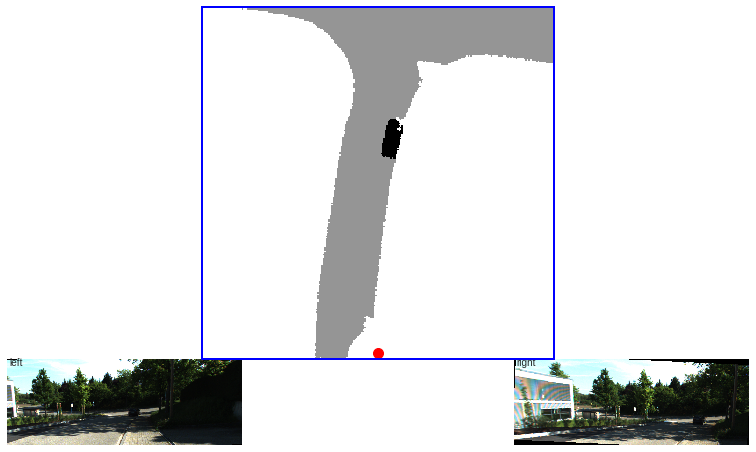

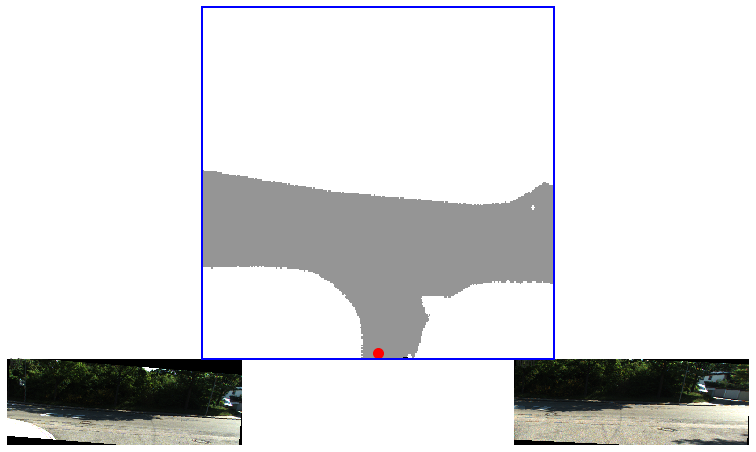

In [8]:
explore_data(data, data_aug_conf, 2)

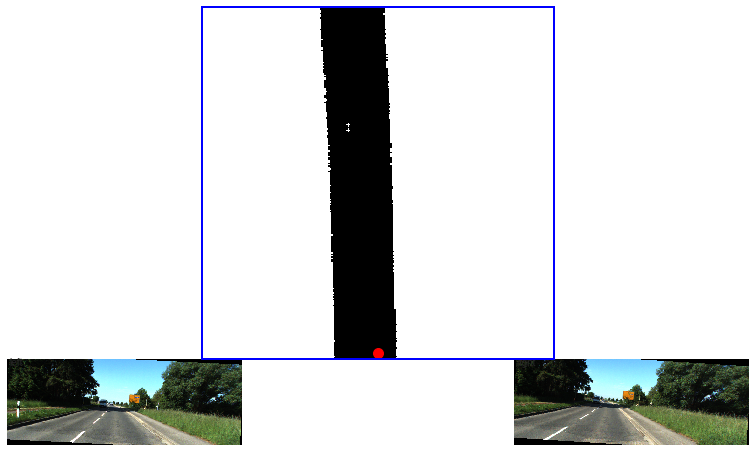

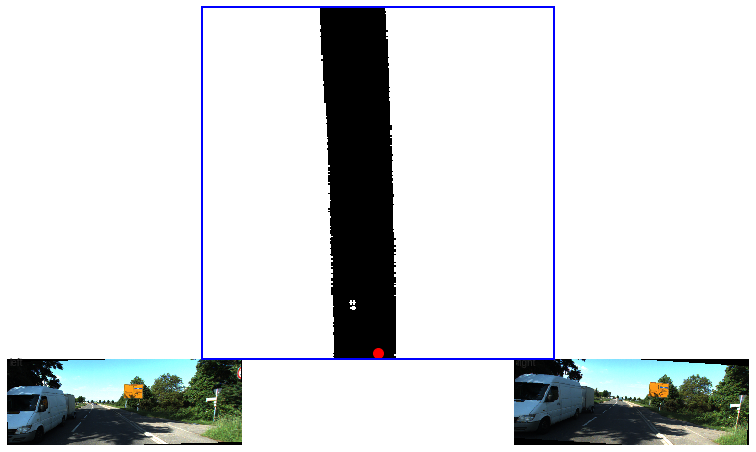

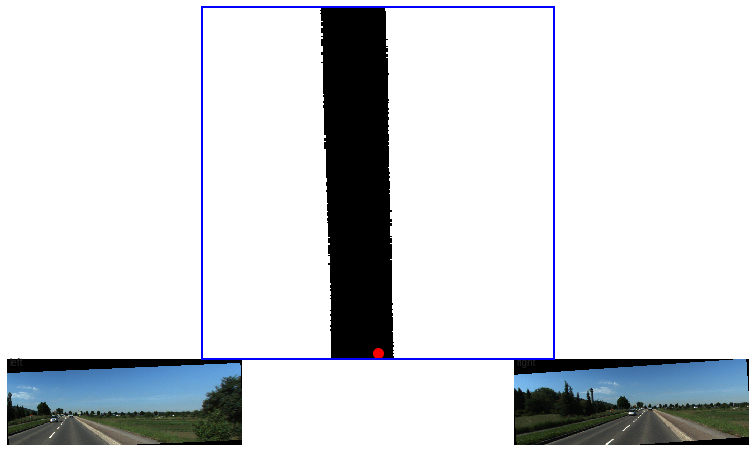

In [9]:
cams = ['left', 'right']

for counter in [0, 1, 2]:
    imgs, rots, trans, intrins, post_rots, post_trans, local_map = data[counter]

    val = 0.01
    fH, fW = data_aug_conf['final_dim']
    fig = plt.figure(figsize=(2*fW*val, (0.5*fW + fH)*val))
    gs = mpl.gridspec.GridSpec(2, 2, height_ratios=(1.5*fW, fH))
    gs.update(wspace=0.0, hspace=0.0, left=0.0, right=1.0, top=1.0, bottom=0.0)

    plt.clf()
    for imgi, img in enumerate(imgs):
        ax = plt.subplot(gs[1 + imgi // 2, imgi % 2])
        showimg = denormalize_img(img)
        plt.imshow(showimg)
        plt.axis('off')
        plt.annotate(cams[imgi], (0.01, 0.92), xycoords='axes fraction')

    ax = plt.subplot(gs[0, :])
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.setp(ax.spines.values(), color='b', linewidth=2)

    # plot local map
    drivable_area = local_map[0, ...]
    cars = local_map[1, ...]
    local_map_vis = drivable_area.detach().clone()
    local_map_vis[cars.bool()] = 2.
    plt.imshow(local_map_vis.squeeze(0), cmap='Greys')
    plt.plot(local_map.size()[2]/2., 5, 'ro', markersize=10)

    plt.xlim((local_map.size()[2], 0))
    plt.ylim((0, local_map.size()[1]))

    plt.show()

### Training

In [10]:
len(data)

988

In [11]:
from torch.utils.data import random_split

# traindata, valdata = random_split(data, [10_000, 1_147], generator=torch.Generator().manual_seed(42))
traindata = KITTI360_Map(cfg, is_train=True)
valdata = KITTI360_Map(cfg, is_train=False)

KITTI360_Map: 988 samples. Split: train.
                   Data Conf: {'dataroot': '/home/ruslan/datasets/KITTI-360/', 'osm_path': '../monolayout/data/osm/', 'train_seqs': ['2013_05_28_drive_0003_sync'], 'val_seqs': ['2013_05_28_drive_0004_sync'], 'H': 376, 'W': 1408, 'resize_lim': [0.7, 0.8], 'final_dim': [256, 704], 'bot_pct_lim': [0.0, 0.22], 'rot_lim': [-5.4, 5.4], 'rand_flip': False, 'ncams': 2, 'cams': ['image_00', 'image_01'], 'classes': ['road', 'car'], 'pretrained_weights_path': './weights/road_cars_kitti360/model_iou_0.47.pt', 'xbound': [0.0, 40.96, 0.16], 'ybound': [-20.48, 20.48, 0.16], 'zbound': [-10.0, 10.0, 20.0], 'dbound': [4.0, 45.0, 1.0]}
KITTI360_Map: 988 samples. Split: val.
                   Data Conf: {'dataroot': '/home/ruslan/datasets/KITTI-360/', 'osm_path': '../monolayout/data/osm/', 'train_seqs': ['2013_05_28_drive_0003_sync'], 'val_seqs': ['2013_05_28_drive_0004_sync'], 'H': 376, 'W': 1408, 'resize_lim': [0.7, 0.8], 'final_dim': [256, 704], 'bot_pct_lim': 

In [19]:
# creating small toy datasets
traindata_small = torch.utils.data.Subset(traindata, list(np.random.choice(range(len(traindata)), 300)) )
valdata_small = torch.utils.data.Subset(valdata, list(np.random.choice(range(len(valdata)), 100)) )

In [20]:
len(traindata_small), len(valdata_small)

(300, 100)

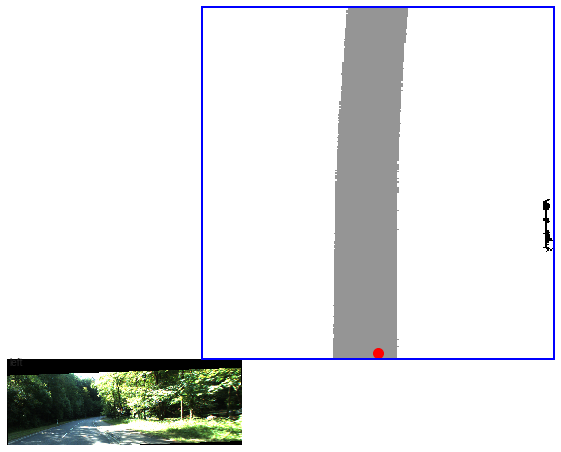

In [21]:
explore_data(traindata_small, data_aug_conf, 1)

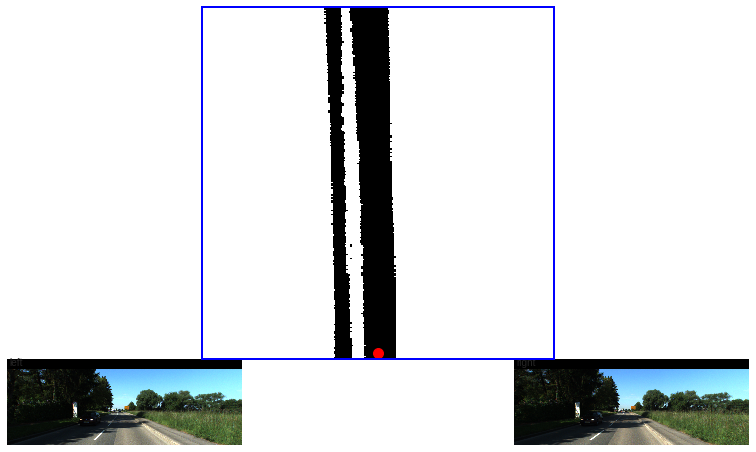

In [23]:
explore_data(valdata_small, data_aug_conf, 1)

In [24]:
bsz=1
nworkers=10
lr=1e-3
weight_decay=1e-7
nepochs = 2
pos_weight=2.13
gpuid=0
max_grad_norm=5.0


def worker_rnd_init(x):
    np.random.seed(13 + x)
    
trainloader = torch.utils.data.DataLoader(traindata_small,
                                          batch_size=bsz,
                                          shuffle=True,
                                          num_workers=nworkers,
                                          drop_last=True,
                                          worker_init_fn=worker_rnd_init)
valloader = torch.utils.data.DataLoader(valdata_small,
                                        batch_size=1,
                                        shuffle=False,
                                        num_workers=nworkers)

In [17]:
# xbound=[0.0, 69.12, 0.16]
# ybound=[-39.68, 39.68, 0.16]
# zbound=[-10.0, 10.0, 20.0]
# dbound=[4.0, 45.0, 1.0]

# grid_conf = {
#     'xbound': xbound,
#     'ybound': ybound,
#     'zbound': zbound,
#     'dbound': dbound,
# }

In [25]:
device = torch.device('cpu') if gpuid < 0 else torch.device(f'cuda:{gpuid}')

model = compile_model(grid_conf, data_aug_conf, outC=len(cfg_data['classes'])+1) # +1 for background

# # load pretrained model (opitional)
# modelf = '../weights/road_cars_kitti360/model_iou_0.47.pt'
# print('loading', modelf)
# model.load_state_dict(torch.load(modelf))

model.to(device)
model.train()

opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

loss_fn = SimpleLoss(pos_weight).cuda(gpuid)

logdir = f'./runs/lss_{time()}'
writer = SummaryWriter(logdir=logdir)

Loaded pretrained weights for efficientnet-b0


In [27]:
counter = 0
max_val_iou = 0.

for epoch in tqdm(range(nepochs)):
    
    np.random.seed()
    for batchi, (imgs, rots, trans, intrins, post_rots, post_trans, binimgs) in enumerate(trainloader):
        t0 = time()
        opt.zero_grad()
        preds = model(imgs.to(device),
                rots.to(device),
                trans.to(device),
                intrins.to(device),
                post_rots.to(device),
                post_trans.to(device),
                )
        binimgs = binimgs.to(device)
        loss = loss_fn(preds, binimgs)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        opt.step()
        counter += 1
        t1 = time()
        
        if counter % 10 == 0:
            print(counter, loss.item())
            writer.add_scalar('train/loss', loss, counter)

        if counter % 50 == 0:
            _, _, iou = get_batch_iou(preds, binimgs)
            writer.add_scalar('train/iou', iou, counter)
            writer.add_scalar('train/epoch', epoch, counter)
            writer.add_scalar('train/step_time', t1 - t0, counter)

        if counter % 50 == 0:
            val_info = get_val_info(model, valloader, loss_fn, device)
            print('VAL', val_info)
            writer.add_scalar('val/loss', val_info['loss'], counter)
            writer.add_scalar('val/iou', val_info['iou'], counter)
            writer.add_scalar('val/iou_static', val_info['iou_static'], counter)
            writer.add_scalar('val/iou_dynamic', val_info['iou_dynamic'], counter)

            if val_info['iou'] > max_val_iou:
                max_val_iou = val_info['iou']
                model.eval()
                mname = os.path.join(logdir, "model_iou_{:.2f}.pt".format(val_info['iou']))
                print('saving', mname)
                torch.save(model.state_dict(), mname)
                model.train()

  0%|          | 0/2 [00:00<?, ?it/s]

10 0.638103723526001
20 0.49448415637016296
30 0.4412640929222107
40 0.33643412590026855
50 0.3196200728416443
running eval...
VAL {'loss': 0.8793687763810157, 'iou': 0.5579983084173198, 'iou_static': 0.383335151677801, 'iou_dynamic': 0.0}
saving ./runs/lss_1610458120.3758466/model_iou_0.56.pt
60 0.6315304040908813
70 0.3588927686214447
80 0.4443163573741913
90 0.2616145610809326
100 0.8871171474456787
running eval...
VAL {'loss': 0.5952772834897041, 'iou': 0.5987525261162262, 'iou_static': 0.40822891832030406, 'iou_dynamic': 0.0}
saving ./runs/lss_1610458120.3758466/model_iou_0.60.pt
110 0.22568687796592712
120 0.24896077811717987
130 0.2558964192867279
140 0.2747693955898285
150 0.24468994140625
running eval...
VAL {'loss': 0.809307433962822, 'iou': 0.6041037894840043, 'iou_static': 0.4363303665643771, 'iou_dynamic': 0.0}
saving ./runs/lss_1610458120.3758466/model_iou_0.60.pt
160 0.6398393511772156
170 0.8104256391525269
180 0.3029763996601105
190 0.2137475609779358
200 0.66723513603

 50%|█████     | 1/2 [01:27<01:27, 87.77s/it]

VAL {'loss': 0.5020431819558143, 'iou': 0.6555659557198953, 'iou_static': 0.4283866055639671, 'iou_dynamic': 0.0}
310 0.19046907126903534
320 0.1552238166332245
330 1.1742851734161377
340 0.18724796175956726
350 0.6003062725067139
running eval...
VAL {'loss': 0.5481240175664425, 'iou': 0.6708159653178258, 'iou_static': 0.461787813774666, 'iou_dynamic': 0.0}
360 0.21531090140342712
370 0.18469184637069702
380 0.1822109818458557
390 0.2555199861526489
400 0.14416882395744324
running eval...
VAL {'loss': 0.42901965737342834, 'iou': 0.7132399712980213, 'iou_static': 0.47110366588004005, 'iou_dynamic': 0.0}
saving ./runs/lss_1610458120.3758466/model_iou_0.71.pt
410 0.21886447072029114
420 0.6223479509353638
430 0.7036811113357544
440 0.4496951103210449
450 0.6094480752944946
running eval...
VAL {'loss': 0.43331814229488375, 'iou': 0.6939647060794101, 'iou_static': 0.44913250232421387, 'iou_dynamic': 0.0}
460 0.2771385908126831
470 0.9721304774284363
480 0.25666937232017517
490 0.21061083674

100%|██████████| 2/2 [02:56<00:00, 88.24s/it]

VAL {'loss': 0.5983489836752415, 'iou': 0.6808317207017927, 'iou_static': 0.46489642741335574, 'iou_dynamic': 0.0}


### Inference

In [12]:
# load the model
from src.models import compile_model

# device = torch.device('cpu') if gpuid < 0 else torch.device(f'cuda:{gpuid}')
device = torch.device('cuda')

modelf = '../weights/road_cars_kitti360_256x256_map/model_iou_0.61.pt'

model = compile_model(grid_conf, data_aug_conf, outC=2)
print('loading', modelf)
model.load_state_dict(torch.load(modelf))
model.to(device);

Loaded pretrained weights for efficientnet-b0
loading ../weights/road_cars_kitti360_256x256_map/model_iou_0.61.pt


Single inference took 0.392 sec on input tensor size torch.Size([2, 3, 256, 704])


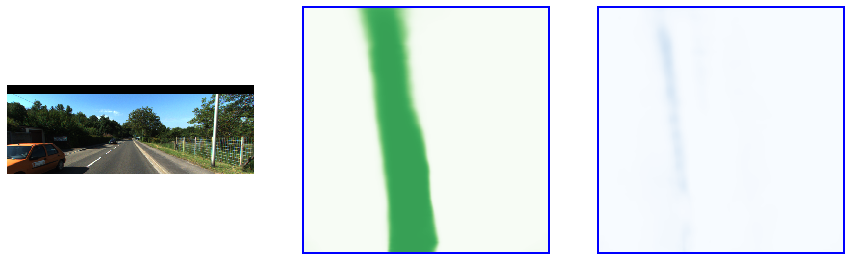

Single inference took 0.046 sec on input tensor size torch.Size([2, 3, 256, 704])


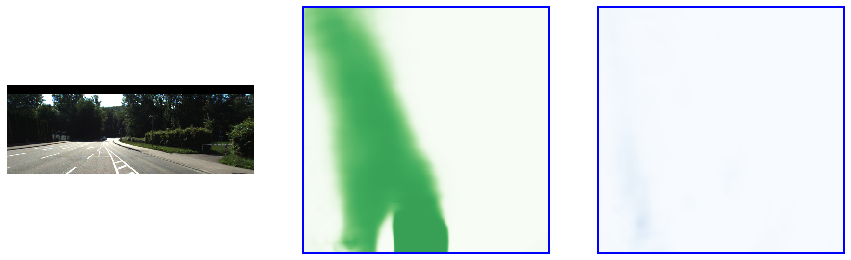

Single inference took 0.046 sec on input tensor size torch.Size([2, 3, 256, 704])


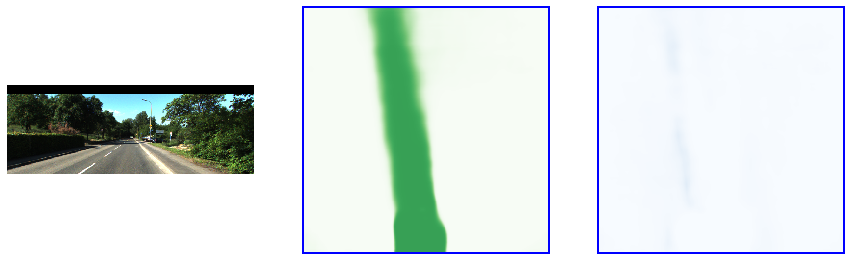

Single inference took 0.054 sec on input tensor size torch.Size([2, 3, 256, 704])


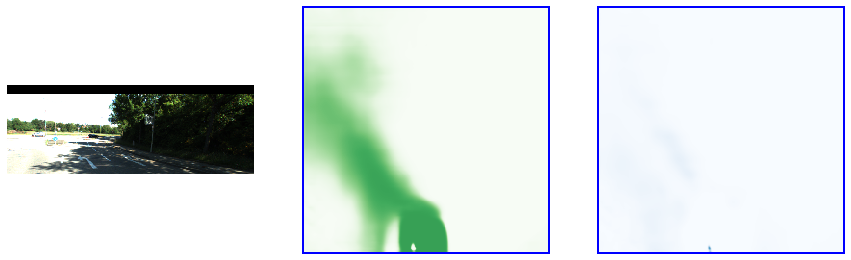

Single inference took 0.040 sec on input tensor size torch.Size([2, 3, 256, 704])


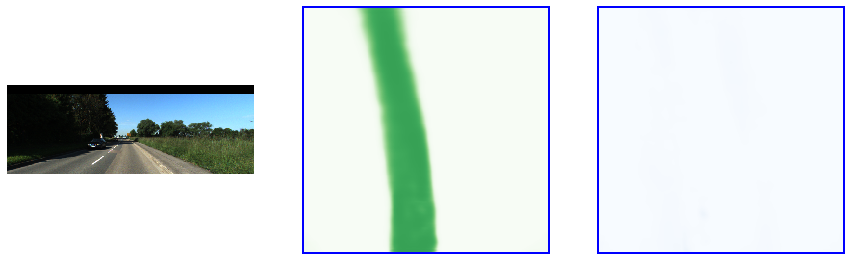

Average FPS: 21.754312072624455 Hz


In [13]:
from time import time

data = valdata

model.eval()

FPS = []
with torch.no_grad():
    np.random.seed(2)
    for counter in np.random.choice(range(len(data)), 5):
        imgs, rots, trans, intrins, post_rots, post_trans, map_binimg = data[counter]
        
        # inference
        t0 = time()
        out = model(imgs.unsqueeze(0).to(device),
                    rots.unsqueeze(0).to(device),
                    trans.unsqueeze(0).to(device),
                    intrins.unsqueeze(0).to(device),
                    post_rots.unsqueeze(0).to(device),
                    post_trans.unsqueeze(0).to(device),
                    )
        dt = time() - t0
        FPS.append(1./dt)
        print(f'Single inference took {dt:.3f} sec on input tensor size {imgs.size()}')
        
#         local_map = pred_to_semseg(out, device)
        road = out.squeeze(0).sigmoid().cpu()[0, ...]
        cars = out.squeeze(0).sigmoid().cpu()[1, ...]

        fig = plt.figure(figsize=(15, 5))

        plt.clf()
        # RGB image
        ax = plt.subplot(1, 3, 1)
        for imgi, img in enumerate(imgs):
            showimg = denormalize_img(img)
            plt.imshow(showimg)
            plt.axis('off')

        # Road map
        ax = plt.subplot(1, 3, 2)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        plt.setp(ax.spines.values(), color='b', linewidth=2)
        # visualize ground truth road map
        road_show = road #> torch.mean(road)
        plt.imshow(road_show, vmin=0, vmax=1.5, cmap='Greens')
        plt.xlim((out.size()[3], 0))
        plt.ylim((0, out.size()[2]))
        
        # Cars map
        ax = plt.subplot(1, 3, 3)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        plt.setp(ax.spines.values(), color='b', linewidth=2)
        # visualize ground truth road map

        cars_show = cars #> 5*torch.mean(cars)
        plt.imshow(cars_show, vmin=0, vmax=1, cmap='Blues')
        plt.xlim((out.size()[3], 0))
        plt.ylim((0, out.size()[2]))

        plt.show()

print(f'Average FPS: {np.mean(FPS[1:])} Hz')